In [118]:
import urllib.request as urllib
import io
import zipfile
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

# download the data from the internet

In [119]:
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open an url
s = io.BytesIO(sock.read())  # read BytesIO file
sock.close()

zf = zipfile.ZipFile(s)  # ZipFile object
# txt = zf.read('football.txt').decode()  # read txt
gml = zf.read('football.gml').decode()  #  read gml data
# delete the first line
gml = gml.split('\n')[1:]
G = nx.parse_gml(gml)  # release gml数据
'''-----------------read data over-------------------'''
# print(txt)
# 打印每个队的度——比赛的数量
# for n, d in G.degree():
#     print('%s %d' % (n, d))

'-----------------read data over-------------------'

# visualize the graph

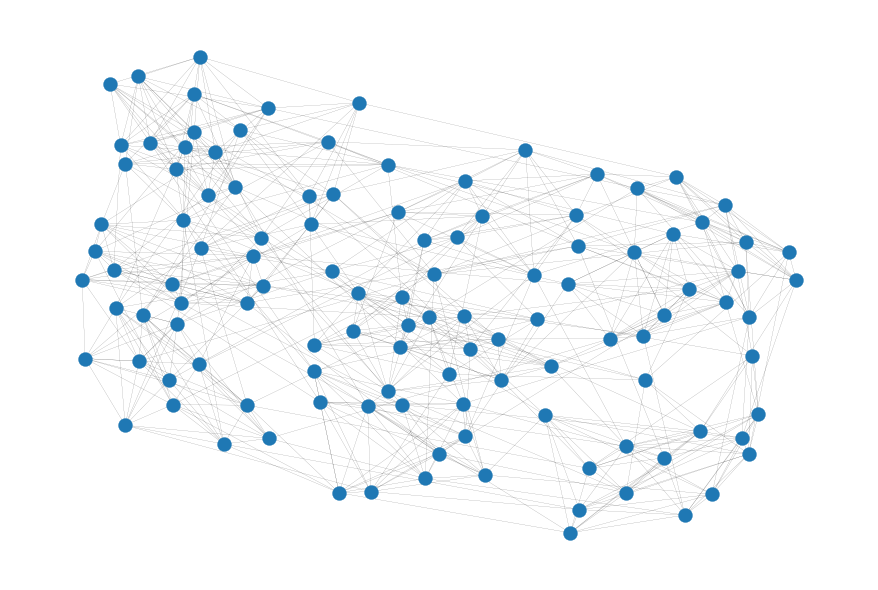

In [120]:
options = {
    # 'node_color': 'black',
    'node_size': 200,
    # 'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.1,
}
# Find key-values for the graph
pos = nx.spring_layout(G)
plt.figure(figsize=[12,8])
nx.draw(G, **options,cmap = plt.get_cmap('rainbow'), pos=pos, with_labels=False)

# print information of the graph

In [121]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes :", str(n))
print("Number of edges :", str(m))
print("Number of connected components :" ,str(nx.number_connected_components(G)))


Number of nodes : 115
Number of edges : 613
Number of connected components : 1


对于无向图而言，115个节点理论上能产生$115*(115-1)/2=6555$条边

那么$D_1$=613，$D_2$=6555-613=5942

首先，先把$D_1$和$D_2$边数据集构造出来

##  构建$D1$,$D2$

In [122]:
D1=list(G.edges)

node_list=list(G.nodes)
D2=[]
for i in range(len(node_list)):
    for j in range(i+1,len(node_list)):
        source,target=node_list[i],node_list[j]
        D2.append((source,target))
# ok，D1,D2构建正常
len(set(D2)&set(D1))

613

##  从$D1$和$D2$中构建数据集$D list$

In [123]:
from random import sample
nums_Dk=10# 构建nums_Dk组数据集
D2_list=[]
# 没有设置随机种子，每次的抽样结果都是不同的
for i in range(nums_Dk):
    D2_sample=sample(D2,len(D1))
    D2_list.append(D2_sample)

# 提取特征

---

##  新的特征提取测试

In [255]:
class FunctionSet:
    def __init__(self,G,Beta=1.84):
        '''
        β是超参数，论文的β为1.84和1.76
        '''
        self.G=G
        self.C=nx.average_clustering(G)
        self.function_list=[getattr(self, name) for name in dir(self) if name[0]!='_' and hasattr(getattr(self, name),'__call__')]
        self.function_name=[func.__name__ for func in self.function_list]
        self.Beta=Beta
    def _run_all(self,Dk,type=1):
        source=np.array([x[0] for x in Dk])[:,np.newaxis]
        target=np.array([x[1] for x in Dk])[:,np.newaxis]
        class_=np.array([type]*len(Dk))[:,np.newaxis]
        feature_data=np.array([[func(edge[0],edge[1]) for func in self.function_list] for edge in Dk])
        feature_data=np.hstack((np.hstack((np.hstack((source,target)),class_)),feature_data))
        feature_column=['source','target','class']+self.function_name
        df_Dk=pd.DataFrame(data=feature_data,columns=feature_column)
        return df_Dk
    # L(z) 计算
    def _L(self,z,common_neighbor):
        return sum(self.G.has_edge(z,w) for w in set(common_neighbor)-set([z]))
    # Jaccard 计算
    def Jaccard(self,u, v):
        union_size = len(set(self.G[u]) | set(self.G[v]))# 取并集
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(self.G, u, v))) / union_size# 交集/并集
    # Common neighbor计算
    def CN(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v)))
    # adamic_adar计算
    def AA(self,u,v):
        return sum(1 / math.log(self.G.degree(w)) for w in nx.common_neighbors(self.G, u, v))
    # RA的计算
    def RA(self,u,v):
        return sum(1 / self.G.degree(w) for w in nx.common_neighbors(self.G, u, v))
    # ADP计算
    def ADP(self,u,v):
        C=nx.average_clustering(self.G)
        return sum(math.pow(self.G.degree(w),-1*self.Beta*C) for w in nx.common_neighbors(G, u, v))
    # CNDP计算
    def CNDP(self,u,v):
        common_neighbor=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,common_neighbor)*math.pow(self.G.degree(z),-1*self.Beta*self.C) for z in common_neighbor)
    # Salton 计算
    def Salton(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /math.sqrt(self.G.degree(u)*self.G.degree(v))
    # Sorensen 计算
    def Sorensen(self,u,v):
        return 2*len(list(nx.common_neighbors(self.G, u, v))) /(self.G.degree(u)+self.G.degree(v))
    # HPI 计算
    def HPI(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /min(self.G.degree(u),self.G.degree(v))
    # HDI 计算
    def HDI(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /max(self.G.degree(u),self.G.degree(v))
    # LHN-I 计算
    def LHN_I(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /(self.G.degree(u)*self.G.degree(v))
    # CAR计算
    def CAR(self,u,v):
        common_neighbor=list(nx.common_neighbors(self.G,u,v))
        return self.CN(u,v)*(1/2)*sum(self._L(z,common_neighbor) for z in common_neighbor)
    # CAA 计算
    def CAA(self,u,v):
        Z=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,Z)/math.log(self.G.degree(z)) for z in Z)
    # CRA 计算
    def CRA(self,u,v):
        Z=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,Z)/self.G.degree(z) for z in Z)
    # CCLP计算
    def CCLP(self,u,v):
        return sum(nx.clustering(self.G,z) for z in nx.common_neighbors(self.G,u,v))
    # NLC计算
    def NLC(self,u,v):
        def tmp_cal(x,y,z_):
            return (self.CN(x,z_)+self.CN(y,z_))/(self.G.degree(z_)-1)
        return sum(nx.clustering(self.G,z)*tmp_cal(u,v,z) for z in nx.common_neighbors(self.G,u,v))
    # MI计算
    # LNB-CN   
    # LNB-AA
    # LNB-RA    

In [228]:
# f = FunctionSet(G)
# function_list=[getattr(f, name) for name in dir(f) if name[0]!='_' and hasattr(getattr(f, name),'__call__')]
# function_name=[func.__name__+'_' for func in function_list]

In [124]:
# # # 特征测试
# # tmp_D2=D2_list[0]
# # # 计算D2边集合的jaccard值
# # jc_list=list(nx.jaccard_coefficient(G,D2))

# # L(z) 计算
# def _L(G,z,common_neighbor):
#     return sum(G.has_edge(z,w) for w in set(common_neighbor)-set([z]))
# # Jaccard 计算
# def Jaccard(G, u, v):
#     union_size = len(set(G[u]) | set(G[v]))# 取并集
#     if union_size == 0:
#         return 0
#     return len(list(nx.common_neighbors(G, u, v))) / union_size# 交集/并集
# # Common neighbor计算
# def CN(G,u,v):
#     return len(list(nx.common_neighbors(G, u, v)))
# # adamic_adar计算
# def AA(G,u,v):
#     return sum(1 / math.log(G.degree(w)) for w in nx.common_neighbors(G, u, v))# sum(x for x in X)
# # RA的计算
# def RA(G,u,v):
#     return sum(1 / G.degree(w) for w in nx.common_neighbors(G, u, v))
# # ADP计算
# def ADP(G,u,v,Beta=1.84):
#     '''
#     β是超参数，论文的β为1.84和1.76
#     '''
#     C=nx.average_clustering(G)
#     return sum(math.pow(G.degree(w),-1*Beta*C) for w in nx.common_neighbors(G, u, v))
# # CNDP计算
# def CNDP(G,u,v,Beta=1.84):
#     '''
#     β是超参数，论文的β为1.84和1.76
#     '''
#     C=nx.average_clustering(G)
#     common_neighbor=list(nx.common_neighbors(G,u,v))
#     # return sum((sum(G.has_edge(z,w) for w in set(Z)-set([z])))*math.pow(G.degree(z),-1*Beta*C) for z in Z)
#     return sum(_L(G,z,common_neighbor)*math.pow(G.degree(z),-1*Beta*C) for z in common_neighbor)
# # Salton 计算
# def Salton(G,u,v):
#     return len(list(nx.common_neighbors(G, u, v))) /math.sqrt(G.degree(u)*G.degree(v))
# # Sorensen 计算
# def Sorensen(G,u,v):
#     return 2*len(list(nx.common_neighbors(G, u, v))) /(G.degree(u)+G.degree(v))
# # HPI 计算
# def HPI(G,u,v):
#     return len(list(nx.common_neighbors(G, u, v))) /min(G.degree(u),G.degree(v))
# # HDI 计算
# def HDI(G,u,v):
#     return len(list(nx.common_neighbors(G, u, v))) /max(G.degree(u),G.degree(v))
# # LHN-I 计算
# def LHN_I(G,u,v):
#     return len(list(nx.common_neighbors(G, u, v))) /(G.degree(u)*G.degree(v))
# # CAR计算
# def CAR(G,u,v):
#     common_neighbor=list(nx.common_neighbors(G,u,v))
#     return CN(G,u,v)*(1/2)*sum(_L(G,z,common_neighbor) for z in common_neighbor)
# # CAA 计算
# def CAA(G,u,v):
#     Z=list(nx.common_neighbors(G,u,v))
#     return sum(_L(G,z,Z)/math.log(G.degree(z)) for z in Z)
# # CRA 计算
# def CRA(G,u,v):
#     Z=list(nx.common_neighbors(G,u,v))
#     return sum(_L(G,z,Z)/G.degree(z) for z in Z)
# # CCLP计算
# def CCLP(G,u,v):
#     return sum(nx.clustering(G,z) for z in nx.common_neighbors(G,u,v))
# # NLC计算
# def NLC(G,u,v):
#     def tmp_cal(x,y,z_):
#         return (CN(G,x,z_)+CN(G,y,z_))/(G.degree(z_)-1)
#     return sum(nx.clustering(G,z)*tmp_cal(u,v,z) for z in nx.common_neighbors(G,u,v))
# # MI计算
# # LNB-CN   
# # LNB-AA
# # LNB-RA    

In [125]:
# function_list=[Jaccard,CN,AA,RA,ADP,CNDP,Salton,Sorensen,HPI,HDI,LHN_I,CAR,CAA,CRA,CCLP,NLC]
# function_name=[func.__name__+'_' for func in function_list]

---

In [126]:
# # num of common neighbors of a and b
# def num_common_neighbors(a,b):
#     return len(list(nx.common_neighbors(G,a,b)))
# # num of neighbors of a/b
# def num_neighbors(node):
#     return len(list(nx.all_neighbors(G,node)))
# # total degrees of neighbors of a/b
# def total_degrees_of_neighbors(node):
#     sum_degree=0
#     for neighbor in sorted(nx.all_neighbors(G,node)):
#         sum_degree = sum_degree + len(list(nx.all_neighbors(G,neighbor)))
#     return sum_degree
# # total dergees of common neighbors of a and b
# def total_degrees_of_common_neighbors(a,b):
#     sum_degree_common=0
#     for neighbor in sorted(nx.common_neighbors(G,a,b)):
#         sum_degree_common = sum_degree_common + len(list(nx.all_neighbors(G,neighbor)))
#     return sum_degree_common


## 先提取D1的

In [256]:
model.function_name

['AA',
 'ADP',
 'CAA',
 'CAR',
 'CCLP',
 'CN',
 'CNDP',
 'CRA',
 'HDI',
 'HPI',
 'Jaccard',
 'LHN_I',
 'L_',
 'NLC',
 'RA',
 'Salton',
 'Sorensen']

In [257]:
model=FunctionSet(G)
df_D1=model._run_all(D1,type=1)
df_D1

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,NLC,RA,Salton,Sorensen
0,BrighamYoung,FloridaState,1,0.43429448190325176,0.18116843789290937,0.0,0.0,0.6444444444444445,1.0,0.0,0.0,0.08333333333333333,0.08333333333333333,0.043478260869565216,0.006944444444444444,0.6444444444444445,0.1,0.08333333333333333,0.08333333333333333
1,BrighamYoung,NewMexico,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.7535353535353537,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.4965595347413525,0.556060606060606,0.5222329678670935,0.5217391304347826
2,BrighamYoung,SanDiegoState,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.698989898989899,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.5303642485460665,0.556060606060606,0.5222329678670935,0.5217391304347826
3,BrighamYoung,Wyoming,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.7535353535353537,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.5416039179675534,0.556060606060606,0.5222329678670935,0.5217391304347826
4,BrighamYoung,Utah,1,2.977235355774506,1.2228828128392037,12.610578712305434,105.0,3.0505050505050506,7.0,5.1349222176501135,2.78030303030303,0.5833333333333334,0.6363636363636364,0.4375,0.05303030303030303,3.4908019589837767,0.6671717171717172,0.6092717958449424,0.6086956521739131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Clemson,Maryland,1,2.9391481338853334,1.195784498545069,17.634888803312002,147.0,3.823232323232323,7.0,7.174706991270416,3.881818181818182,0.6363636363636364,0.7,0.5,0.06363636363636363,5.50055300479543,0.6469696969696971,0.6674238124719146,0.6666666666666666
609,NevadaLasVegas,Hawaii,1,0.40242960438184466,0.15824740269906445,0.0,0.0,0.48484848484848486,1.0,0.0,0.0,0.08333333333333333,0.09090909090909091,0.045454545454545456,0.007575757575757576,0.48484848484848486,0.08333333333333333,0.08703882797784893,0.08695652173913043
610,WakeForest,Maryland,1,2.9391481338853334,1.195784498545069,17.634888803312002,147.0,3.778787878787879,7.0,7.174706991270416,3.881818181818182,0.6363636363636364,0.7,0.5,0.06363636363636363,5.53687174778084,0.6469696969696971,0.6674238124719146,0.6666666666666666
611,OregonState,California,1,2.4875915615030757,1.0022476777742968,9.950366246012303,72.0,2.793939393939394,6.0,4.008990711097187,2.151515151515152,0.5454545454545454,0.6,0.4,0.05454545454545454,3.407933884297521,0.537878787878788,0.5720775535473553,0.5714285714285714


In [42]:
# # a
# source1=[x[0] for x in D1]
# # b
# target1=[x[1] for x in D1]
# # num of common neighbors of a and b
# common_neighbors1=[num_common_neighbors(x[0],x[1]) for x in D1]
# # num of neighbors of a
# neighbor_a1=[num_neighbors(x) for x in source1]
# # num of neighbors of b
# neighbor_b1=[num_neighbors(x) for x in target1]
# # total degrees of neighbors of a
# totoal_degree_neighbor_a1=[total_degrees_of_neighbors(x) for x in source1]
# # total degrees of neighbors of b
# totoal_degree_neighbor_b1=[total_degrees_of_neighbors(x) for x in target1]
# # total dergees of common neighbors of a and b
# total_degree_common_neighbor1=[total_degrees_of_common_neighbors(x[0],x[1]) for x in D1]


# df_D1=pd.DataFrame({
#     'source':source1,
#     'target':target1,
#     'common_neighbors':common_neighbors1,
#     'neighbor_a':neighbor_a1,
#     'neighbor_b':neighbor_b1,
#     'totoal_degree_neighbors_a':totoal_degree_neighbor_a1,
#     'totoal_degree_neighbors_b':totoal_degree_neighbor_b1,
#     'total_degree_common_neighbor':total_degree_common_neighbor1,
#     'class':[1]*len(D1)
# })

## 提取D2的

### 数据结构

In [247]:
# df list
df_D2_list=[]
for Dk in D2_list:
    df=model._run_all(Dk,type=0)
    df_D2_list.append(df)
df_D2_list[0]

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,L_,NLC,RA,Salton,Sorensen
0,Rice,Rutgers,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FresnoState,Idaho,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BostonCollege,Arkansas,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BowlingGreenState,EastCarolina,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Memphis,Toledo,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Illinois,OregonState,0,0.8340647828484926,0.337600110030093,0.0,0.0,0.9454545454545454,2.0,0.0,0.0,0.18181818181818182,0.2,0.10526315789473684,0.01818181818181818,0.0,0.3781818181818182,0.18181818181818182,0.19069251784911848,0.19047619047619047
609,Duke,NewMexicoState,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,NorthernIllinois,SouthCarolina,0,0.4170323914242463,0.1688000550150465,0.0,0.0,0.2909090909090909,1.0,0.0,0.0,0.09090909090909091,0.1,0.05,0.00909090909090909,0.0,0.14545454545454545,0.09090909090909091,0.09534625892455924,0.09523809523809523
611,Baylor,Clemson,0,0.43429448190325176,0.18116843789290937,0.0,0.0,0.4222222222222222,1.0,0.0,0.0,0.1,0.1,0.05263157894736842,0.01,0.0,0.1876543209876543,0.1,0.1,0.1


In [114]:
# # df list
# df_D2_list=[]
# for Dk in D2_list:
#     source=np.array([x[0] for x in Dk])[:,np.newaxis]
#     target=np.array([x[1] for x in Dk])[:,np.newaxis]
#     class_=np.array([0]*len(Dk))[:,np.newaxis]
#     feature_data=np.array([[func(G,edge[0],edge[1]) for func in function_list]for edge in Dk])
#     feature_data=np.hstack((np.hstack((np.hstack((source1,target1)),class_)),feature_data))
#     feature_column=['source','target','class']+function_name.copy()
#     df=pd.DataFrame(data=feature_data,columns=feature_column)
#     df_D2_list.append(df)
# df_D2_list[0]

,source,target,class,Jaccard_,CN_,AA_,RA_,Salton_,Sorensen_,HPI_,HDI_,LHN_I_,CAR_,CAA_,CRA_,CCLP_,NLC_
0,BrighamYoung,FloridaState,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BrighamYoung,NewMexico,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BrighamYoung,SanDiegoState,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BrighamYoung,Wyoming,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BrighamYoung,Utah,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Clemson,Maryland,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,NevadaLasVegas,Hawaii,0,0.05263157894736842,1.0,0.4170323914242463,0.09090909090909091,0.1,0.1,0.1,0.1,0.01,0.0,0.0,0.0,0.34545454545454546,0.20727272727272728
610,WakeForest,Maryland,0,0.35294117647058826,6.0,2.5021943485454776,0.5454545454545455,0.5222329678670935,0.5217391304347826,0.5454545454545454,0.5,0.045454545454545456,60.0,8.340647828484926,1.8181818181818181,2.327272727272727,2.483636363636364
611,OregonState,California,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# for edges in D2_list:
#     source_=[x[0] for x in edges]
#     target_=[x[1] for x in edges]
#     common_neighbors_=[num_common_neighbors(x[0],x[1]) for x in edges]
#     neighbor_a_=[num_neighbors(x) for x in source_]
#     neighbor_b_=[num_neighbors(x) for x in target_]
#     total_degree_neighbor_a_=[total_degrees_of_neighbors(x) for x in source_]
#     total_degree_neighbor_b_=[total_degrees_of_neighbors(x) for x in target_]
#     total_degree_common_neighbor_=[total_degrees_of_common_neighbors(x[0],x[1]) for x in edges]

#     df_D2=pd.DataFrame({
#         'source':source_,
#         'target':target_,
#         'common_neighbors':common_neighbors_,
#         'neighbor_a':neighbor_a_,
#         'neighbor_b':neighbor_b_,
#         'totoal_degree_neighbors_a':total_degree_neighbor_a_,
#         'totoal_degree_neighbors_b':total_degree_neighbor_b_,
#         'total_degree_common_neighbor':total_degree_common_neighbor_,
#         'class':[0]*len(edges)
#     })
#     df_D2_list.append(df_D2)

In [49]:
# df_D2_list[0]

,source,target,common_neighbors,neighbor_a,neighbor_b,totoal_degree_neighbors_a,totoal_degree_neighbors_b,total_degree_common_neighbor,class
0,OhioState,Cincinnati,2,11,11,124,119,23,0
1,Florida,Tulsa,0,11,12,116,132,0,0
2,Virginia,EastCarolina,2,10,11,110,118,22,0
3,PennState,ArizonaState,1,12,11,131,119,12,0
4,SouthernMethodist,California,1,12,11,133,121,11,0
...,...,...,...,...,...,...,...,...,...
608,Colorado,Duke,0,11,11,119,119,0,0
609,Iowa,BallState,2,12,10,134,103,22,0
610,Northwestern,Wyoming,0,11,11,122,122,0,0
611,Purdue,EastCarolina,0,11,11,122,118,0,0


## 构造 df_list

In [248]:
from sklearn.utils import shuffle
df_list=[]
for df_D2_ in df_D2_list:
    tmp_list=[df_D1,df_D2_]
    tmp_df=pd.concat(tmp_list)
    tmp_df=shuffle(tmp_df)
    tmp_df=tmp_df.reset_index(drop=True)
    df_list.append(tmp_df)

In [249]:
df_list[0]

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,L_,NLC,RA,Salton,Sorensen
0,Baylor,Wyoming,0,0.4170323914242463,0.1688000550150465,0.0,0.0,0.36363636363636365,1.0,0.0,0.0,0.09090909090909091,0.1,0.05,0.00909090909090909,0.0,0.18181818181818182,0.09090909090909091,0.09534625892455924,0.09523809523809523
1,Florida,Kentucky,1,2.536718529503489,1.0375370958460048,7.5928934980314615,54.0,2.3757575757575755,6.0,3.100242904660151,1.6818181818181817,0.5454545454545454,0.6,0.4,0.05454545454545454,0.0,2.3418630751964087,0.5636363636363636,0.5720775535473553,0.5714285714285714
2,Stanford,California,1,2.5048536519820814,1.0146160606521597,10.019414607928326,72.0,2.898989898989899,6.0,4.058464242608639,2.187878787878788,0.5454545454545454,0.5454545454545454,0.375,0.049586776859504134,0.0,3.682656871747781,0.546969696969697,0.5454545454545454,0.5454545454545454
3,Oregon,OregonState,1,2.4875915615030757,1.0022476777742968,9.950366246012303,72.0,2.83030303030303,6.0,4.008990711097187,2.151515151515152,0.5454545454545454,0.6,0.4,0.05454545454545454,0.0,3.504297520661157,0.537878787878788,0.5720775535473553,0.5714285714285714
4,Northwestern,BallState,0,0.43429448190325176,0.18116843789290937,0.0,0.0,0.3333333333333333,1.0,0.0,0.0,0.09090909090909091,0.1,0.05,0.00909090909090909,0.0,0.18518518518518517,0.1,0.09534625892455924,0.09523809523809523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,Stanford,WashingtonState,1,2.5048536519820814,1.0146160606521597,10.019414607928326,72.0,2.898989898989899,6.0,4.058464242608639,2.187878787878788,0.5454545454545454,0.5454545454545454,0.375,0.049586776859504134,0.0,3.729929599020508,0.546969696969697,0.5454545454545454,0.5454545454545454
1222,Florida,Rutgers,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1223,OhioState,Illinois,1,2.055956383036428,0.8228949704432683,5.736233970642637,35.0,1.8606060606060608,5.0,2.2893322039987765,1.2196969696969697,0.45454545454545453,0.45454545454545453,0.29411764705882354,0.04132231404958678,0.0,1.9295316804407712,0.43939393939393945,0.45454545454545453,0.45454545454545453
1224,Auburn,Alabama,0,2.1196861380792424,0.8687370408309583,5.942026022813481,35.0,1.9393939393939394,5.0,2.437411067477828,1.3272727272727274,0.45454545454545453,0.45454545454545453,0.29411764705882354,0.04132231404958678,0.0,2.0468911335578004,0.47272727272727266,0.45454545454545453,0.45454545454545453


## 保存文件

In [250]:
import os
os_path='df_list\\'
for i,df in enumerate(df_list):
    df_name='df_'+str(i)
    file_path=os.path.join(os_path,df_name)
    df.to_csv(file_path)